In [1]:
# =========================
# Setup
# =========================
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

ROOT = Path("..")
DATA = ROOT / "data"

# Processed panel
PROC_COMPARE = DATA / "processed" / "compare"
PANEL_PATH   = PROC_COMPARE / "daily_panel.parquet"

# Processed features (from 07_build_features.ipynb)
PROC_FEATURES = DATA / "processed" / "features"
FEATURES_PATH = PROC_FEATURES / "daily_features.parquet"

# Event dates
EVENT_V3_LAUNCH = dt.date(2021, 5, 5)
EVENT_FTX       = dt.date(2022, 11, 10)

# Matplotlib defaults (simple & clean)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Figure output location & helpers
FIG_DIR = ROOT / "reports" / "figures" / "descriptives"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# =========================
# Helpers
# =========================

def savefig(name: str, exts=("png", "svg")) -> None:
    """Save current matplotlib figure in reports/figures/descriptives as PNG (raster) and SVG (vector)."""
    fig = plt.gcf()
    fig.tight_layout()
    for ext in exts:
        fig.savefig(
            FIG_DIR / f"{name}.{ext}",
            dpi=150 if ext.lower() == "png" else None,
            bbox_inches="tight",
            metadata={"Title": name}
        )

def add_event_vlines(ax, show_legend: bool = True):
    """
    Add vertical reference lines (with labels) for major events and optionally include them in the legend.
    To combine event lines with the series legend, call with show_legend=False here
    and then call ax.legend(...) once after plotting the series.
    """
    v3  = ax.axvline(EVENT_V3_LAUNCH, linestyle="--", linewidth=1, color="tab:blue",
                     label="Uniswap v3 launch (2021-05-05)")
    ftx = ax.axvline(EVENT_FTX,       linestyle="--", linewidth=1, color="tab:red",
                     label="FTX collapse (2022-11-10)")
    if show_legend:
        ax.legend(handles=[v3, ftx], frameon=False, loc="upper left")
    return ax

def _zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m, st = s.mean(), s.std(ddof=0)
    return (s - m) / (st + 1e-9)

In [3]:
# =========================
# Load panel & features
# =========================
panel = pd.read_parquet(PANEL_PATH)
print(f"[loaded] {PANEL_PATH} rows={len(panel):,} from {panel['date'].min()} to {panel['date'].max()}")

if FEATURES_PATH.exists():
    feat = pd.read_parquet(FEATURES_PATH)
    print(f"[loaded] {FEATURES_PATH} rows={len(feat):,}")
else:
    feat = None
    print("[info] features file not found; proceeding with panel-only descriptives.")

# If features exist, prefer them for numeric analysis (v3_share, gas, etc.)
df = feat if feat is not None else panel.copy()

# Safe numeric casts
for c in ["volumeUSD", "ret", "eth_median_effective_gas_price_gwei",
          "proxy_chl","proxy_cs","proxy_amihud","proxy_roll","v3_share"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("== Snapshot ==")
print(f"labels: {df['label'].nunique()} | venues: {df['venue'].nunique()} | venue_types: {sorted(df['venue_type'].dropna().unique().tolist())}")
print(f"date range: {df['date'].min()} → {df['date'].max()}")

[loaded] ..\data\processed\compare\daily_panel.parquet rows=55,804 from 2021-03-01 to 2023-02-28
[loaded] ..\data\processed\features\daily_features.parquet rows=67,910
== Snapshot ==
labels: 20 | venues: 9 | venue_types: ['CEX', 'DEX']
date range: 2021-03-01 → 2023-02-28


In [4]:
# =========================
# Coverage & schema checks
# =========================
print("\n[Columns]")
print(sorted(df.columns))

print("\n[Head]")
display(df.head(3))
print("\n[Tail]")
display(df.tail(3))

# Coverage by venue_type
cov = (df.groupby("venue_type")["date"]
         .agg(n_days="nunique", start="min", end="max", rows="size")
         .reset_index()
         .sort_values("rows", ascending=False))
print("\n[Coverage by venue_type]")
display(cov)

# Coverage by label × venue_type
lab_cov = (df.groupby(["label","venue_type"])["date"]
             .agg(n_days="nunique", start="min", end="max", rows="size")
             .reset_index()
             .sort_values(["label","venue_type"]))
print("\n[Coverage by label × venue_type] (first 30)")
display(lab_cov.head(30))


[Columns]
['abs_ret', 'close', 'date', 'dex_total_volumeUSD', 'eth_median_base_fee_gwei', 'eth_median_effective_gas_price_gwei', 'eth_median_priority_fee_gwei', 'eth_median_total_fee_gwei', 'eth_n_blocks', 'eth_n_blocks_with_basefee', 'eth_n_txs', 'exchange', 'high', 'is_cex', 'is_dex', 'is_uniswap_v3', 'label', 'log_volumeUSD', 'low', 'post_ftx', 'post_v3', 'proxy_amihud', 'proxy_chl', 'proxy_cs', 'proxy_roll', 'ret', 'ret2', 'symbol', 'v3_share', 'v3_share_filled', 'v3_volumeUSD', 'venue', 'venue_type', 'volumeUSD']

[Head]


,date,venue_type,venue,exchange,label,close,high,low,ret,volumeUSD,proxy_amihud,proxy_roll,symbol,proxy_chl,proxy_cs,eth_median_base_fee_gwei,eth_median_priority_fee_gwei,eth_median_effective_gas_price_gwei,eth_median_total_fee_gwei,eth_n_blocks_with_basefee,eth_n_blocks,eth_n_txs,dex_total_volumeUSD,v3_volumeUSD,v3_share,v3_share_filled,log_volumeUSD,abs_ret,ret2,is_dex,is_cex,is_uniswap_v3,post_v3,post_ftx
0,2021-03-01,CEX,binance,binance,AAVE-ETH,0.24537,0.26534,0.23778,-0.019014,1.753662e+03,1.084222e-05,0.024747,AAVE/ETH,NaN,0.465987,NaN,NaN,105.994308,NaN,0,6340,1185925,5.086411e+06,NaN,NaN,0.0,7.469462,0.019014,0.000362,0,1,0,0,0
1,2021-03-01,DEX,uniswap_v2,uniswap_v2,AAVE-ETH,NaN,NaN,NaN,NaN,5.086411e+06,4.871577e-09,0.031381,None,NaN,NaN,NaN,NaN,105.994308,NaN,0,6340,1185925,5.086411e+06,NaN,NaN,0.0,15.442083,NaN,NaN,1,0,0,0,0
2,2021-03-02,CEX,binance,binance,AAVE-ETH,0.26259,0.26814,0.24257,0.067827,2.064193e+03,3.285866e-05,0.026983,AAVE/ETH,NaN,0.354863,NaN,NaN,112.818716,NaN,0,6438,1240182,5.234286e+06,NaN,NaN,0.0,7.632495,0.067827,0.004600,0,1,0,0,0



[Tail]


,date,venue_type,venue,exchange,label,close,high,low,ret,volumeUSD,proxy_amihud,proxy_roll,symbol,proxy_chl,proxy_cs,eth_median_base_fee_gwei,eth_median_priority_fee_gwei,eth_median_effective_gas_price_gwei,eth_median_total_fee_gwei,eth_n_blocks_with_basefee,eth_n_blocks,eth_n_txs,dex_total_volumeUSD,v3_volumeUSD,v3_share,v3_share_filled,log_volumeUSD,abs_ret,ret2,is_dex,is_cex,is_uniswap_v3,post_v3,post_ftx
67907,2023-02-28,DEX,uniswap_v3_all,uniswap_v3_all,USDC-USDT,NaN,NaN,NaN,NaN,1.305893e+08,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,2.617850e+08,2.611786e+08,0.997684,0.997684,18.687568,NaN,NaN,1,0,1,1,1
67908,2023-02-28,DEX,uniswap_v3_fee100,uniswap_v3_fee100,USDC-USDT,NaN,NaN,NaN,NaN,1.284112e+08,4.118466e-14,0.000079,None,NaN,NaN,21.103792,0.865904,23.517229,23.517229,1044634,7104,1044634,2.617850e+08,2.611786e+08,0.997684,0.997684,18.670748,NaN,NaN,1,0,1,1,1
67909,2023-02-28,DEX,uniswap_v3_fee500,uniswap_v3_fee500,USDC-USDT,NaN,NaN,NaN,NaN,2.178141e+06,6.168622e-11,0.000094,None,NaN,NaN,21.103792,0.865904,23.517229,23.517229,1044634,7104,1044634,2.617850e+08,2.611786e+08,0.997684,0.997684,14.593982,NaN,NaN,1,0,1,1,1



[Coverage by venue_type]


,venue_type,n_days,start,end,rows
1,DEX,730,2021-03-01,2023-02-28,52093
0,CEX,730,2021-03-01,2023-02-28,15817



[Coverage by label × venue_type] (first 30)


,label,venue_type,n_days,start,end,rows
0,AAVE-ETH,CEX,730,2021-03-01,2023-02-28,730
1,AAVE-ETH,DEX,730,2021-03-01,2023-02-28,2659
2,BAT-ETH,CEX,730,2021-03-01,2023-02-28,1460
3,BAT-ETH,DEX,730,2021-03-01,2023-02-28,2389
4,BTC-DAI,CEX,730,2021-03-01,2023-02-28,730
5,BTC-DAI,DEX,730,2021-03-01,2023-02-28,2218
6,BTC-USDC,CEX,730,2021-03-01,2023-02-28,1308
7,BTC-USDC,DEX,730,2021-03-01,2023-02-28,2733
8,CRV-ETH,CEX,403,2022-01-22,2023-02-28,403
9,CRV-ETH,DEX,730,2021-03-01,2023-02-28,2724


In [5]:
# =========================
# Descriptives — Volumes
# =========================
vol_cols = [c for c in ["volumeUSD"] if c in df.columns]
if vol_cols:
    by_vt = (df.groupby("venue_type")[vol_cols]
               .agg(["count","median","mean","std","min","max"]))
    print("\n[VolumeUSD by venue_type]")
    display(by_vt)

    by_venue = (df.groupby("venue")[vol_cols]
                  .agg(["count","median","mean","std"])
                  .sort_values(("volumeUSD","mean"), ascending=False))
    print("\n[VolumeUSD by venue] (top 15)")
    display(by_venue.head(15))
else:
    print("[info] 'volumeUSD' not found; skipping volume descriptives.")


[VolumeUSD by venue_type]


volumeUSD                                                                   
               count         median          mean           std       min           max
venue_type                                                                             
CEX            15817    1900.747147  1.588112e+08  4.521738e+08  0.056547  1.148513e+10
DEX            52093  274847.337375  2.793259e+07  1.113977e+08  0.000000  2.635120e+09


[VolumeUSD by venue] (top 15)


volumeUSD                                          
                        count        median          mean           std
venue                                                                  
coinbase                 4264  6.485423e+03  2.168878e+08  3.728283e+08
binance                  9363  3.805932e+02  1.457625e+08  5.212285e+08
okx                      2190  5.966552e+06  1.015215e+08  1.845707e+08
uniswap_v3_fee500        5468  8.361546e+06  8.756622e+07  2.015601e+08
uniswap_v3_all          12106  1.368349e+06  5.688798e+07  1.698364e+08
uniswap_v3_fee100        1519  5.256230e+05  3.562248e+07  6.235795e+07
uniswap_v3_fee3000       9758  1.077697e+06  1.575705e+07  4.186884e+07
uniswap_v2              14483  1.625162e+05  5.366342e+06  2.186525e+07
uniswap_v3_fee10000      8759  5.252886e+03  2.290240e+05  8.657022e+05

In [6]:
# =========================
# Descriptives — Returns
# =========================
if "ret" in df.columns:
    ret_by_vt = (df.groupby("venue_type")["ret"]
                   .agg(count="count", mean="mean", median="median", std="std",
                        p1=lambda s: s.quantile(0.01),
                        p99=lambda s: s.quantile(0.99))
                   .reset_index())
    print("\n[Return stats by venue_type]")
    display(ret_by_vt)
else:
    print("[info] 'ret' not found; skipping return descriptives.")


[Return stats by venue_type]


,venue_type,count,mean,median,std,p1,p99
0,CEX,15817,-0.000854,-0.000119,0.043274,-0.11449,0.125278
1,DEX,0,NaN,NaN,NaN,NaN,NaN


In [7]:
# =========================
# Descriptives — CEX liquidity proxies (tabular)
# =========================
proxy_cols = [c for c in ["proxy_chl","proxy_cs","proxy_amihud","proxy_roll"] if c in df.columns]
if proxy_cols:
    cex_only = df.loc[df["venue_type"] == "CEX"].copy()
    if not cex_only.empty:
        prox_stats = (cex_only[["venue"] + proxy_cols]
                      .groupby("venue")
                      .agg(["count","median","mean","std","min","max"])
                      .sort_values((proxy_cols[0], "median"), ascending=True))
        print("\n[Liquidity proxy stats by CEX venue] (per-proxy)")
        display(prox_stats.head(20))
    else:
        print("[info] no CEX rows found for proxies.")
else:
    print("[info] proxy_* columns not found; skipping proxy descriptives.")


[Liquidity proxy stats by CEX venue] (per-proxy)


proxy_chl                                                       proxy_cs                                                   proxy_amihud  \
             count    median      mean       std           min       max    count    median      mean       std       min       max        count   
venue                                                                                                                                              
okx           1269  0.001639  0.005752  0.008507  5.563866e-07  0.048983     2190  0.007865  0.089452  0.138904  0.000341  1.427900         2190   
coinbase      1940  0.013641  0.015552  0.009548  2.284259e-04  0.053599     4264  0.187763  0.220888  0.142803  0.022899  1.895811         4264   
binance       4901  0.014102  0.016356  0.012092  1.544480e-07  0.105984     9363  0.190396  0.220775  0.154344  0.000341  1.919429         9363   

                                                                      proxy_roll                                                        
                median          mean           std  min           max      count    median      mean       std           min       max  
venue                                                                                                                                   
okx       9.516966e-11  3.522843e-10  1.058926e-09  0.0  1.962564e-08       1908  0.000484  0.009894  0.019853  4.473590e-07  0.140828  
coinbase  9.424495e-09  9.674146e-04  5.216688e-03  0.0  1.137403e-01       2651  0.027685  0.032129  0.021749  2.317648e-04  0.187247  
binance   4.399894e-05  3.631557e-04  1.238018e-03  0.0  4.990759e-02       5902  0.026321  0.029636  0.022496  1.183385e-06  0.198330

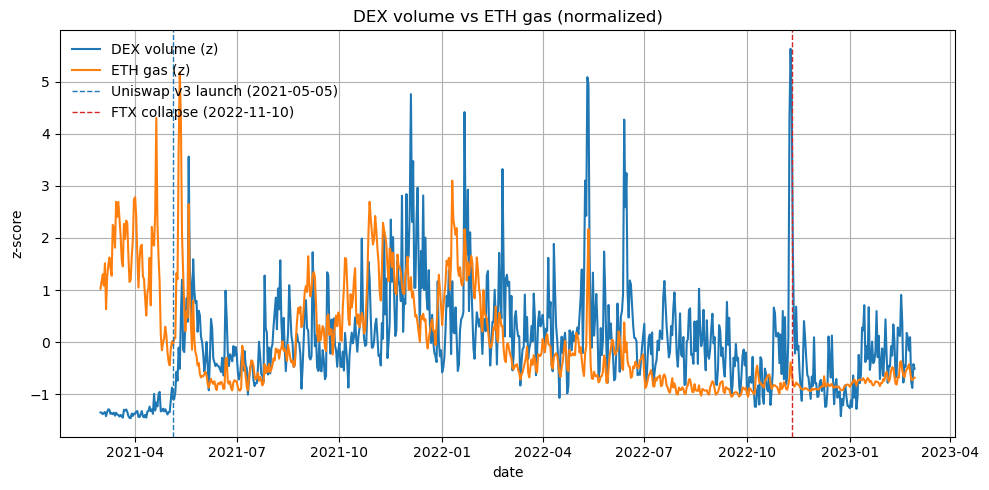

In [8]:
# =========================
# Visual — DEX volume vs ETH gas (normalized)
# =========================
need = {"volumeUSD","eth_median_effective_gas_price_gwei","venue_type"}
if need.issubset(df.columns):
    dex_daily = (df.loc[df["venue_type"]=="DEX"]
                   .groupby("date")["volumeUSD"]
                   .sum()
                   .reset_index(name="DEX volume (z)"))
    gas_daily = (df.groupby("date")["eth_median_effective_gas_price_gwei"]
                   .mean()
                   .reset_index(name="ETH gas (z)"))
    m = dex_daily.merge(gas_daily, on="date", how="inner")
    # z-score
    for c in ["DEX volume (z)","ETH gas (z)"]:
        m[c] = _zscore(m[c])

    ax = m.plot(x="date", y=["DEX volume (z)","ETH gas (z)"], kind="line")
    ax.set_title("DEX volume vs ETH gas (normalized)")
    ax.set_xlabel("date"); ax.set_ylabel("z-score")

    # Add event lines (no legend here), then build ONE combined legend
    add_event_vlines(ax, show_legend=False)
    ax.legend(frameon=False, loc="upper left")
    savefig("04_dex_volume_vs_eth_gas_normalized")
    plt.show()
else:
    print("[info] need both 'volumeUSD' and 'eth_median_effective_gas_price_gwei' for the comparison plot.")

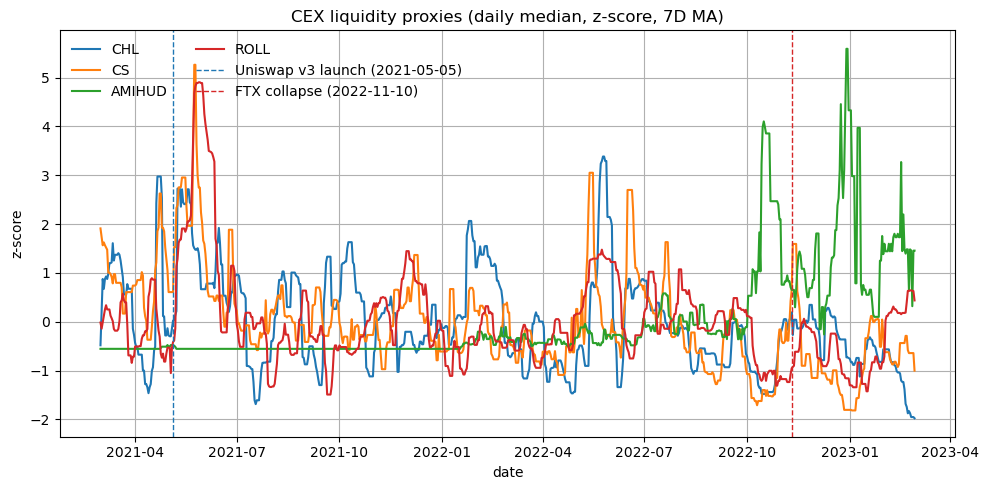

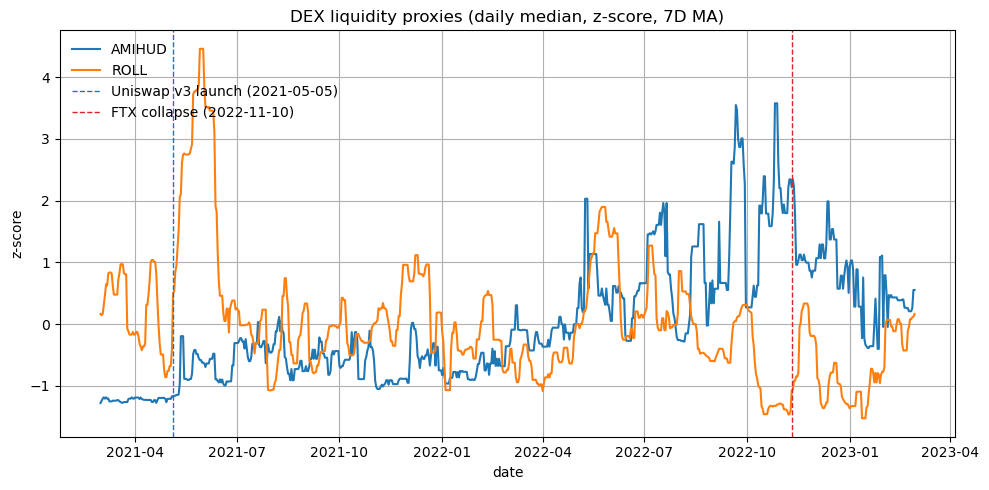

In [9]:
# =========================
# Visual — Proxies time-series (daily median, z-score, 7D MA)
# =========================
proxy_all = [c for c in ["proxy_chl","proxy_cs","proxy_amihud","proxy_roll"] if c in df.columns]

if proxy_all:
    # -------- CEX proxies (CHL/CS/Amihud/Roll) --------
    cex = df.loc[df["venue_type"]=="CEX", ["date"] + proxy_all].copy()
    if not cex.empty:
        daily_cex = (cex.groupby("date")[proxy_all]
                       .median()
                       .rolling(7, min_periods=1)
                       .median())  # smoother
        # Rename to legend labels BEFORE plotting
        rename_map = { "proxy_chl":"CHL", "proxy_cs":"CS", "proxy_amihud":"AMIHUD", "proxy_roll":"ROLL" }
        daily_cex = daily_cex.rename(columns={k:v for k,v in rename_map.items() if k in daily_cex.columns})
        daily_cex_z = daily_cex.apply(_zscore)

        ax = daily_cex_z.plot()
        ax.set_title("CEX liquidity proxies (daily median, z-score, 7D MA)")
        ax.set_xlabel("date"); ax.set_ylabel("z-score")

        # Event lines + combined legend
        add_event_vlines(ax, show_legend=False)
        ax.legend(frameon=False, loc="upper left", ncol=2)
        savefig("06_cex_proxies_timeseries_z")
        plt.show()
    else:
        print("[info] no CEX rows found for proxy time-series.")

    # -------- DEX proxies (Amihud/Roll only) --------
    dex = df.loc[df["venue_type"]=="DEX", ["date"] + proxy_all].copy()
    dex_cols = [c for c in ["proxy_amihud","proxy_roll"] if c in dex.columns]
    if dex_cols:
        daily_dex = (dex.groupby("date")[dex_cols]
                       .median()
                       .rolling(7, min_periods=1)
                       .median())
        rename_map = { "proxy_amihud":"AMIHUD", "proxy_roll":"ROLL" }
        daily_dex = daily_dex.rename(columns={k:v for k,v in rename_map.items() if k in daily_dex.columns})
        daily_dex_z = daily_dex.apply(_zscore)

        ax = daily_dex_z.plot()
        ax.set_title("DEX liquidity proxies (daily median, z-score, 7D MA)")
        ax.set_xlabel("date"); ax.set_ylabel("z-score")

        # Event lines + combined legend
        add_event_vlines(ax, show_legend=False)
        ax.legend(frameon=False, loc="upper left")
        savefig("07_dex_proxies_timeseries_z")
        plt.show()
    else:
        print("[info] DEX proxy columns not present; skipping DEX proxy time-series.")
else:
    print("[info] proxy_* columns not found; skipping proxy time-series visuals.")


[v3_share daily mean across labels] (head)


,date,v3_share_mean
0,2021-03-01,NaN
1,2021-03-02,NaN
2,2021-03-03,NaN
3,2021-03-04,NaN
4,2021-03-05,NaN


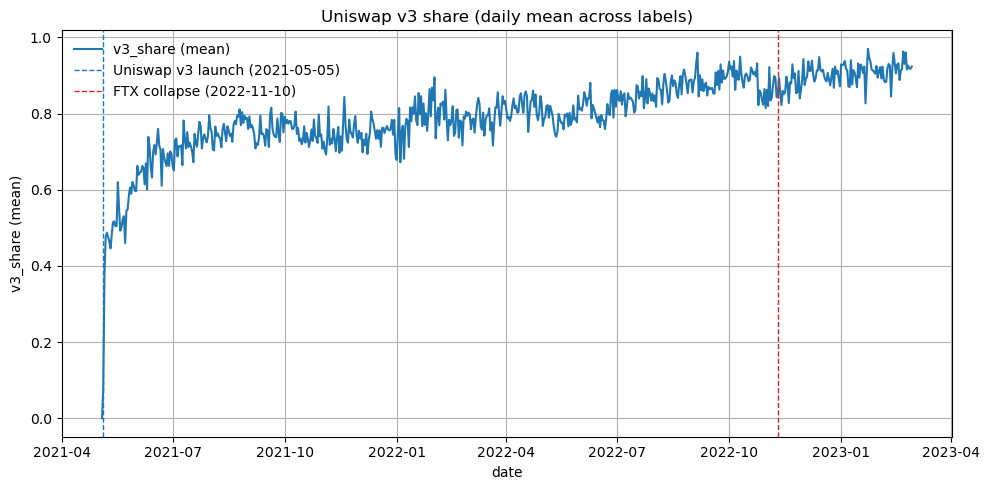


[Overall mean v3_share by label]


,label,v3_share_mean
0,BTC-USDC,0.995567
1,USDC-USDT,0.981585
2,ETH-BTC,0.979270
3,DAI-USDT,0.976453
4,ETH-USDC,0.970567
5,DAI-ETH,0.934832
6,ETH-USDT,0.919016
7,LINK-ETH,0.903626
8,BAT-ETH,0.839752
9,CRV-ETH,0.801241


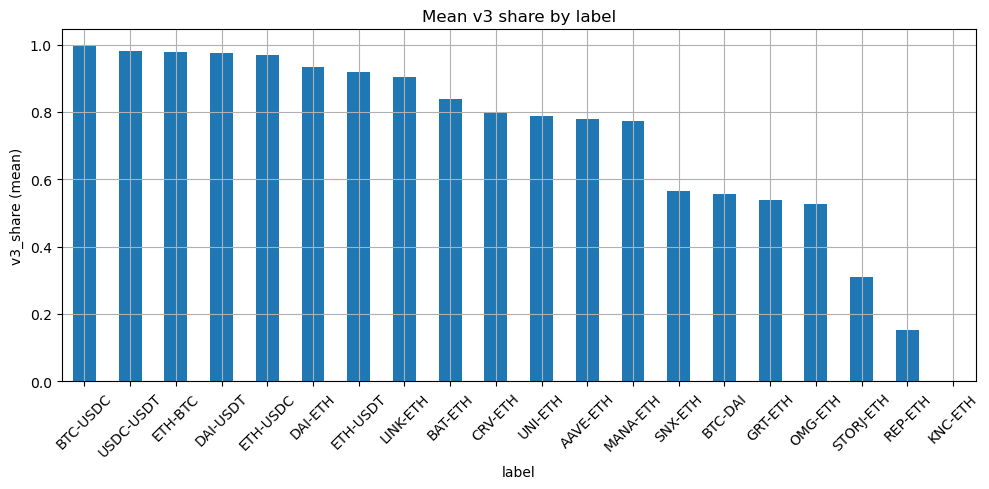

In [10]:
# =========================
# Descriptives — v3 share (features)
# =========================
def _has_v3_share(d):
    return "v3_share" in d.columns

if _has_v3_share(df):
    dex = df.loc[df["venue_type"] == "DEX"].copy()
    # Daily mean v3 share across labels (DEX-only)
    daily_v3 = (dex.groupby("date")["v3_share"]
                  .mean()
                  .reset_index(name="v3_share_mean"))
    print("\n[v3_share daily mean across labels] (head)")
    display(daily_v3.head(5))

    ax = daily_v3.plot(x="date", y="v3_share_mean", kind="line", legend=False)
    ax.set_title("Uniswap v3 share (daily mean across labels)")
    ax.set_xlabel("date"); ax.set_ylabel("v3_share (mean)")
    add_event_vlines(ax, show_legend=False)
    ax.legend(["v3_share (mean)",
               "Uniswap v3 launch (2021-05-05)",
               "FTX collapse (2022-11-10)"], frameon=False, loc="upper left")
    savefig("01_v3_share_daily_mean")
    plt.show()

    # v3 share by label (overall mean)
    lab_v3 = (dex.groupby("label")["v3_share"]
                .mean()
                .sort_values(ascending=False)
                .rename("v3_share_mean")
                .reset_index())
    print("\n[Overall mean v3_share by label]")
    display(lab_v3)

    ax = lab_v3.plot(x="label", y="v3_share_mean", kind="bar", legend=False, rot=45)
    ax.set_title("Mean v3 share by label")
    ax.set_xlabel("label"); ax.set_ylabel("v3_share (mean)")
    plt.tight_layout()
    savefig("02_v3_share_by_label_bar")
    plt.show()
else:
    print("[info] 'v3_share' not found; consider re-running 07_build_features.ipynb.")


[ETH gas-fee summary stats]


,count,median,mean,std,min,max
eth_median_base_fee_gwei,45905.0,2.894159e+01,4.404073e+01,37.583220,4.112115,2.019384e+02
eth_median_priority_fee_gwei,45905.0,1.916127e+00,2.236097e+00,1.270744,0.667699,1.099005e+01
eth_median_effective_gas_price_gwei,55804.0,3.411319e+01,5.222813e+01,45.449066,5.834902,3.068426e+02
eth_median_total_fee_gwei,45905.0,3.322704e+01,4.949397e+01,40.983234,5.834902,2.062762e+02
eth_n_blocks_with_basefee,55804.0,1.110579e+06,9.375787e+05,447091.213796,0.000000,1.932711e+06
eth_n_blocks,55804.0,6.331000e+03,6.446587e+03,436.749956,5152.000000,7.177000e+03
eth_n_txs,55804.0,1.159942e+06,1.167617e+06,128715.733102,742785.000000,1.932711e+06


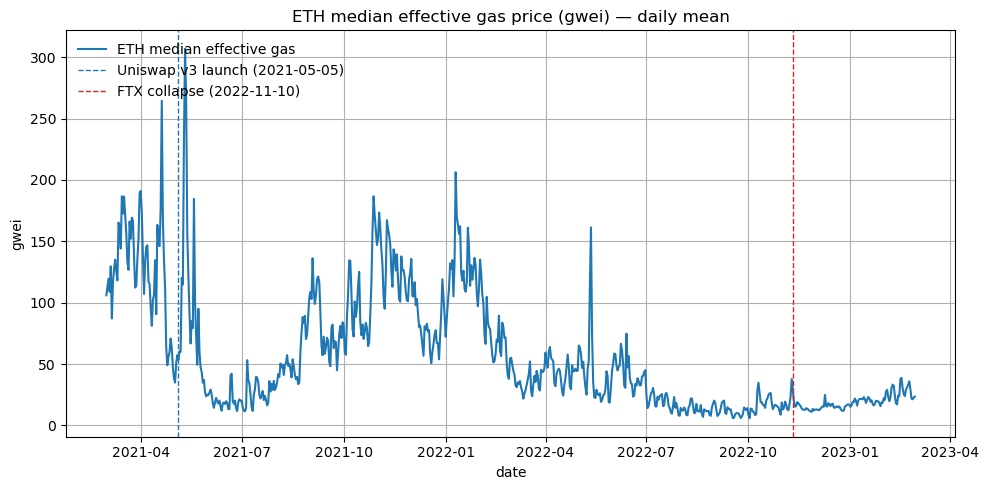

In [11]:
# =========================
# ETH gas fees — descriptives
# =========================
gas_cols = [c for c in df.columns if c.startswith("eth_median_") or c.startswith("eth_n_")]
if gas_cols:
    gas_stats = df[gas_cols].agg(["count","median","mean","std","min","max"]).T
    print("\n[ETH gas-fee summary stats]")
    display(gas_stats)

    g_daily = (df.groupby("date")["eth_median_effective_gas_price_gwei"]
                 .mean()
                 .reset_index())
    ax = g_daily.plot(x="date", y="eth_median_effective_gas_price_gwei", kind="line", legend=False)
    ax.set_title("ETH median effective gas price (gwei) — daily mean")
    ax.set_xlabel("date"); ax.set_ylabel("gwei")
    add_event_vlines(ax, show_legend=False)
    ax.legend(["ETH median effective gas",
               "Uniswap v3 launch (2021-05-05)",
               "FTX collapse (2022-11-10)"], frameon=False, loc="upper left")
    savefig("03_eth_median_effective_gas_price_daily")
    plt.show()
else:
    print("[info] ETH gas columns not found; confirm data merge in panel.")

In [12]:
# =========================
# Aggregates for event-window tables
# =========================
def _window(df, center_date, days=30):
    start = center_date - dt.timedelta(days=days)
    end   = center_date + dt.timedelta(days=days)
    return df.loc[(df["date"] >= start) & (df["date"] <= end)].copy()

dex = df.loc[df["venue_type"] == "DEX"].copy()
tables = {}

# v3 launch window
win_v3 = _window(dex, EVENT_V3_LAUNCH, days=30)
tab_v3 = (win_v3
          .assign(period=lambda d: np.where(d["date"] < EVENT_V3_LAUNCH, "pre", "post"))
          .groupby("period")
          .agg(
              days=("date","nunique"),
              volumeUSD_mean=("volumeUSD","mean"),
              volumeUSD_median=("volumeUSD","median"),
              v3_share_mean=("v3_share","mean") if "v3_share" in win_v3.columns else ("volumeUSD","size")
          )
          .reset_index())
tables["v3_window"] = tab_v3

# FTX window
win_ftx = _window(dex, EVENT_FTX, days=30)
tab_ftx = (win_ftx
          .assign(period=lambda d: np.where(d["date"] < EVENT_FTX, "pre", "post"))
          .groupby("period")
          .agg(
              days=("date","nunique"),
              volumeUSD_mean=("volumeUSD","mean"),
              volumeUSD_median=("volumeUSD","median"),
              v3_share_mean=("v3_share","mean") if "v3_share" in win_ftx.columns else ("volumeUSD","size")
          )
          .reset_index())
tables["ftx_window"] = tab_ftx

print("\n[Event-window aggregates] (±30 days) — v3 launch")
display(tables["v3_window"])
print("\n[Event-window aggregates] (±30 days) — FTX collapse")
display(tables["ftx_window"])


[Event-window aggregates] (±30 days) — v3 launch


,period,days,volumeUSD_mean,volumeUSD_median,v3_share_mean
0,post,31,3.217062e+07,6.575127e+05,0.525649
1,pre,30,2.032715e+07,2.031472e+06,0.000000



[Event-window aggregates] (±30 days) — FTX collapse


,period,days,volumeUSD_mean,volumeUSD_median,v3_share_mean
0,post,31,2.020969e+07,79495.164473,0.882515
1,pre,30,2.437817e+07,74448.127580,0.874524


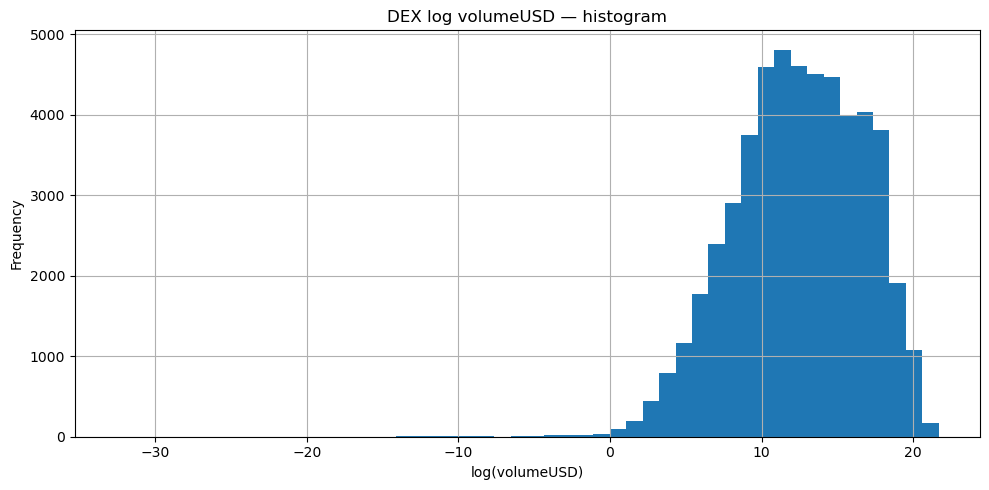

In [13]:
# =========================
# Visual — Histogram of log-volumeUSD (DEX only)
# =========================
if "volumeUSD" in df.columns:
    dex = df.loc[(df["venue_type"] == "DEX") & (df["volumeUSD"] > 0)].copy()
    if not dex.empty:
        dex["log_volumeUSD"] = np.log(dex["volumeUSD"])
        ax = dex["log_volumeUSD"].plot(kind="hist", bins=50)
        ax.set_title("DEX log volumeUSD — histogram")
        ax.set_xlabel("log(volumeUSD)")
        savefig("05_dex_log_volume_histogram")
        plt.show()

In [14]:
# =========================
# Save summary tables (optional)
# =========================
REPORTS = ROOT / "reports" / "tables" / "descriptives"
REPORTS.mkdir(parents=True, exist_ok=True)

try:
    if 'by_vt' in globals():
        by_vt.to_csv(REPORTS / "volume_by_venue_type.csv")
    if 'by_venue' in globals():
        by_venue.head(50).to_csv(REPORTS / "volume_by_venue_top50.csv", index=True)
    if 'ret_by_vt' in globals():
        ret_by_vt.to_csv(REPORTS / "returns_by_venue_type.csv", index=False)
    if 'prox_stats' in globals():
        prox_stats.to_csv(REPORTS / "cex_proxy_stats.csv")
    if gas_cols:
        gas_stats.to_csv(REPORTS / "eth_gas_stats.csv")
    for name, tab in (tables or {}).items():
        tab.to_csv(REPORTS / f"{name}.csv", index=False)
    print(f"[OK] wrote summary tables -> {REPORTS}")
except Exception as e:
    print(f"[WARN] could not write some summaries: {e}")

[OK] wrote summary tables -> ..\reports\tables\descriptives
